<a href="https://colab.research.google.com/github/sankichi92/satelliteBook/blob/main/notebooks/3-2-coordinate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3-2 衛星データと地上データを組み合わせる準備

[『Pythonで学ぶ衛星データ解析基礎』](https://gihyo.jp/book/2022/978-4-297-13232-3)第3章 衛星データ解析準備より。

In [1]:
!date --rfc-3339=seconds

2023-01-09 09:50:03+00:00


In [2]:
!python --version

Python 3.8.16


In [3]:
!pip install japanize-matplotlib>=1.1.3 geopandas>=0.12.2

In [4]:
%config InlineBackend.figure_formats = ['retina']

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 100

import japanize_matplotlib

In [6]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

## GeoPandas の基本

https://github.com/sorabatake/article_20455_geopandas より、marriage.csv を読み込む。

In [7]:
import pandas as pd

raw_marriage = pd.read_csv('https://raw.githubusercontent.com/sorabatake/article_20455_geopandas/8ed83ebf34525070986800ecfa8bff52b561b0dd/input/marriage.csv')
raw_marriage

,cat01_code,年齢(5歳階級),cat02_code,世帯の主な仕事,cat03_code,総数・再掲,cat04_code,夫・妻,area_code,都道府県（特別区−指定都市再掲）,time_code,時間軸(年次),unit,value
0,80,平均初婚年齢,100,総数,100,総数,100,夫,1000,北海道,2019000000,2019年,歳,30.8
1,80,平均初婚年齢,100,総数,100,総数,100,夫,1000,北海道,2018000000,2018年,歳,30.8
2,80,平均初婚年齢,100,総数,100,総数,100,夫,1000,北海道,2017000000,2017年,歳,30.8
3,80,平均初婚年齢,100,総数,100,総数,100,夫,1000,北海道,2016000000,2016年,歳,30.8
4,80,平均初婚年齢,100,総数,100,総数,100,夫,1000,北海道,2015000000,2015年,歳,30.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,80,平均初婚年齢,100,総数,100,総数,110,妻,43100,熊本市,2019000000,2019年,歳,29.5
676,80,平均初婚年齢,100,総数,100,総数,110,妻,43100,熊本市,2018000000,2018年,歳,29.3
677,80,平均初婚年齢,100,総数,100,総数,110,妻,43100,熊本市,2017000000,2017年,歳,29.6
678,80,平均初婚年齢,100,総数,100,総数,110,妻,43100,熊本市,2016000000,2016年,歳,29.2


日本語のカラム名を英語にし、不要なカラムを除く。

In [8]:
marriage = raw_marriage.rename(columns={'夫・妻': 'sex', '都道府県（特別区−指定都市再掲）': 'prefecture', '時間軸(年次)': 'year', 'value': 'ave_age'})
marriage = marriage[['sex', 'year', 'prefecture', 'ave_age']]
marriage

,sex,year,prefecture,ave_age
0,夫,2019年,北海道,30.8
1,夫,2018年,北海道,30.8
2,夫,2017年,北海道,30.8
3,夫,2016年,北海道,30.8
4,夫,2015年,北海道,30.7
...,...,...,...,...
675,妻,2019年,熊本市,29.5
676,妻,2018年,熊本市,29.3
677,妻,2017年,熊本市,29.6
678,妻,2016年,熊本市,29.2


都道府県以外のデータを除く。

In [9]:
marriage = marriage[marriage['prefecture'].str.contains(r'[都道府県]$')]

性別・年ごとに平均初婚年齢が最小・最大の都道府県を見る。

In [10]:
marriage.loc[marriage.groupby(['sex', 'year'])['ave_age'].idxmin()]

,sex,year,prefecture,ave_age
224,夫,2015年,宮崎県,30.0
223,夫,2016年,宮崎県,30.1
202,夫,2017年,佐賀県,29.9
221,夫,2018年,宮崎県,29.9
155,夫,2019年,島根県,30.2
374,妻,2015年,福島県,28.6
373,妻,2016年,福島県,28.6
542,妻,2017年,佐賀県,28.5
501,妻,2018年,岡山県,28.7
500,妻,2019年,岡山県,28.7


In [11]:
marriage.loc[marriage.groupby(['sex', 'year'])['ave_age'].idxmax()]

,sex,year,prefecture,ave_age
64,夫,2015年,東京都,32.5
63,夫,2016年,東京都,32.4
62,夫,2017年,東京都,32.4
61,夫,2018年,東京都,32.3
60,夫,2019年,東京都,32.4
404,妻,2015年,東京都,30.7
403,妻,2016年,東京都,30.6
402,妻,2017年,東京都,30.5
401,妻,2018年,東京都,30.5
400,妻,2019年,東京都,30.6


[GADM](https://gadm.org/download_country.html) から日本の都道府県の行政界を GeoPandas で読み込む。

In [12]:
import fiona

# レイヤ名を確認: https://gis.stackexchange.com/questions/255138/reading-the-names-of-geodatabase-file-layers-in-python
fiona.listlayers('https://geodata.ucdavis.edu/gadm/gadm4.1/gpkg/gadm41_JPN.gpkg')

['ADM_ADM_0', 'ADM_ADM_1', 'ADM_ADM_2']

In [13]:
import geopandas as gpd

raw_jpn_adm = gpd.read_file('https://geodata.ucdavis.edu/gadm/gadm4.1/gpkg/gadm41_JPN.gpkg', layer='ADM_ADM_1')

In [14]:
raw_jpn_adm.drop('geometry', axis=1)

,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1
0,JPN.1_1,JPN,Japan,Aichi,Aiti,愛知県,Ken,Prefecture,NA,JP.AI,JP-23
1,JPN.2_1,JPN,Japan,Akita,NA,秋田県,Ken,Prefecture,NA,JP.AK,JP-05
2,JPN.3_1,JPN,Japan,Aomori,NA,青森県,Ken,Prefecture,NA,JP.AO,JP-02
3,JPN.4_1,JPN,Japan,Chiba,Tiba|Tsiba,千葉県,Ken,Prefecture,NA,JP.CH,JP-12
4,JPN.5_1,JPN,Japan,Ehime,NA,愛媛県,Ken,Prefecture,NA,JP.EH,JP-38
5,JPN.6_1,JPN,Japan,Fukui,Hukui,福井県,Ken,Prefecture,NA,JP.FI,JP-18
6,JPN.7_1,JPN,Japan,Fukuoka,Hukuoka,福岡県,Ken,Prefecture,NA,JP.FO,JP-40
7,JPN.8_1,JPN,Japan,Fukushima,Hukusima,福島県,Ken,Prefecture,NA,JP.FS,JP-07
8,JPN.9_1,JPN,Japan,Gifu,Gihu,岐阜県,Ken,Prefecture,NA,JP.GF,JP-21
9,JPN.10_1,JPN,Japan,Gunma,GunmaGumma,群馬県,Ken,Prefecture,NA,JP.GM,JP-10


カラム名を改善し、不要なカラムを除く。

In [15]:
jpn_adm = raw_jpn_adm.rename(columns={'NL_NAME_1': 'prefecture'})[['prefecture', 'geometry']]

都道府県名のラベルをつけて行政界を表示する。

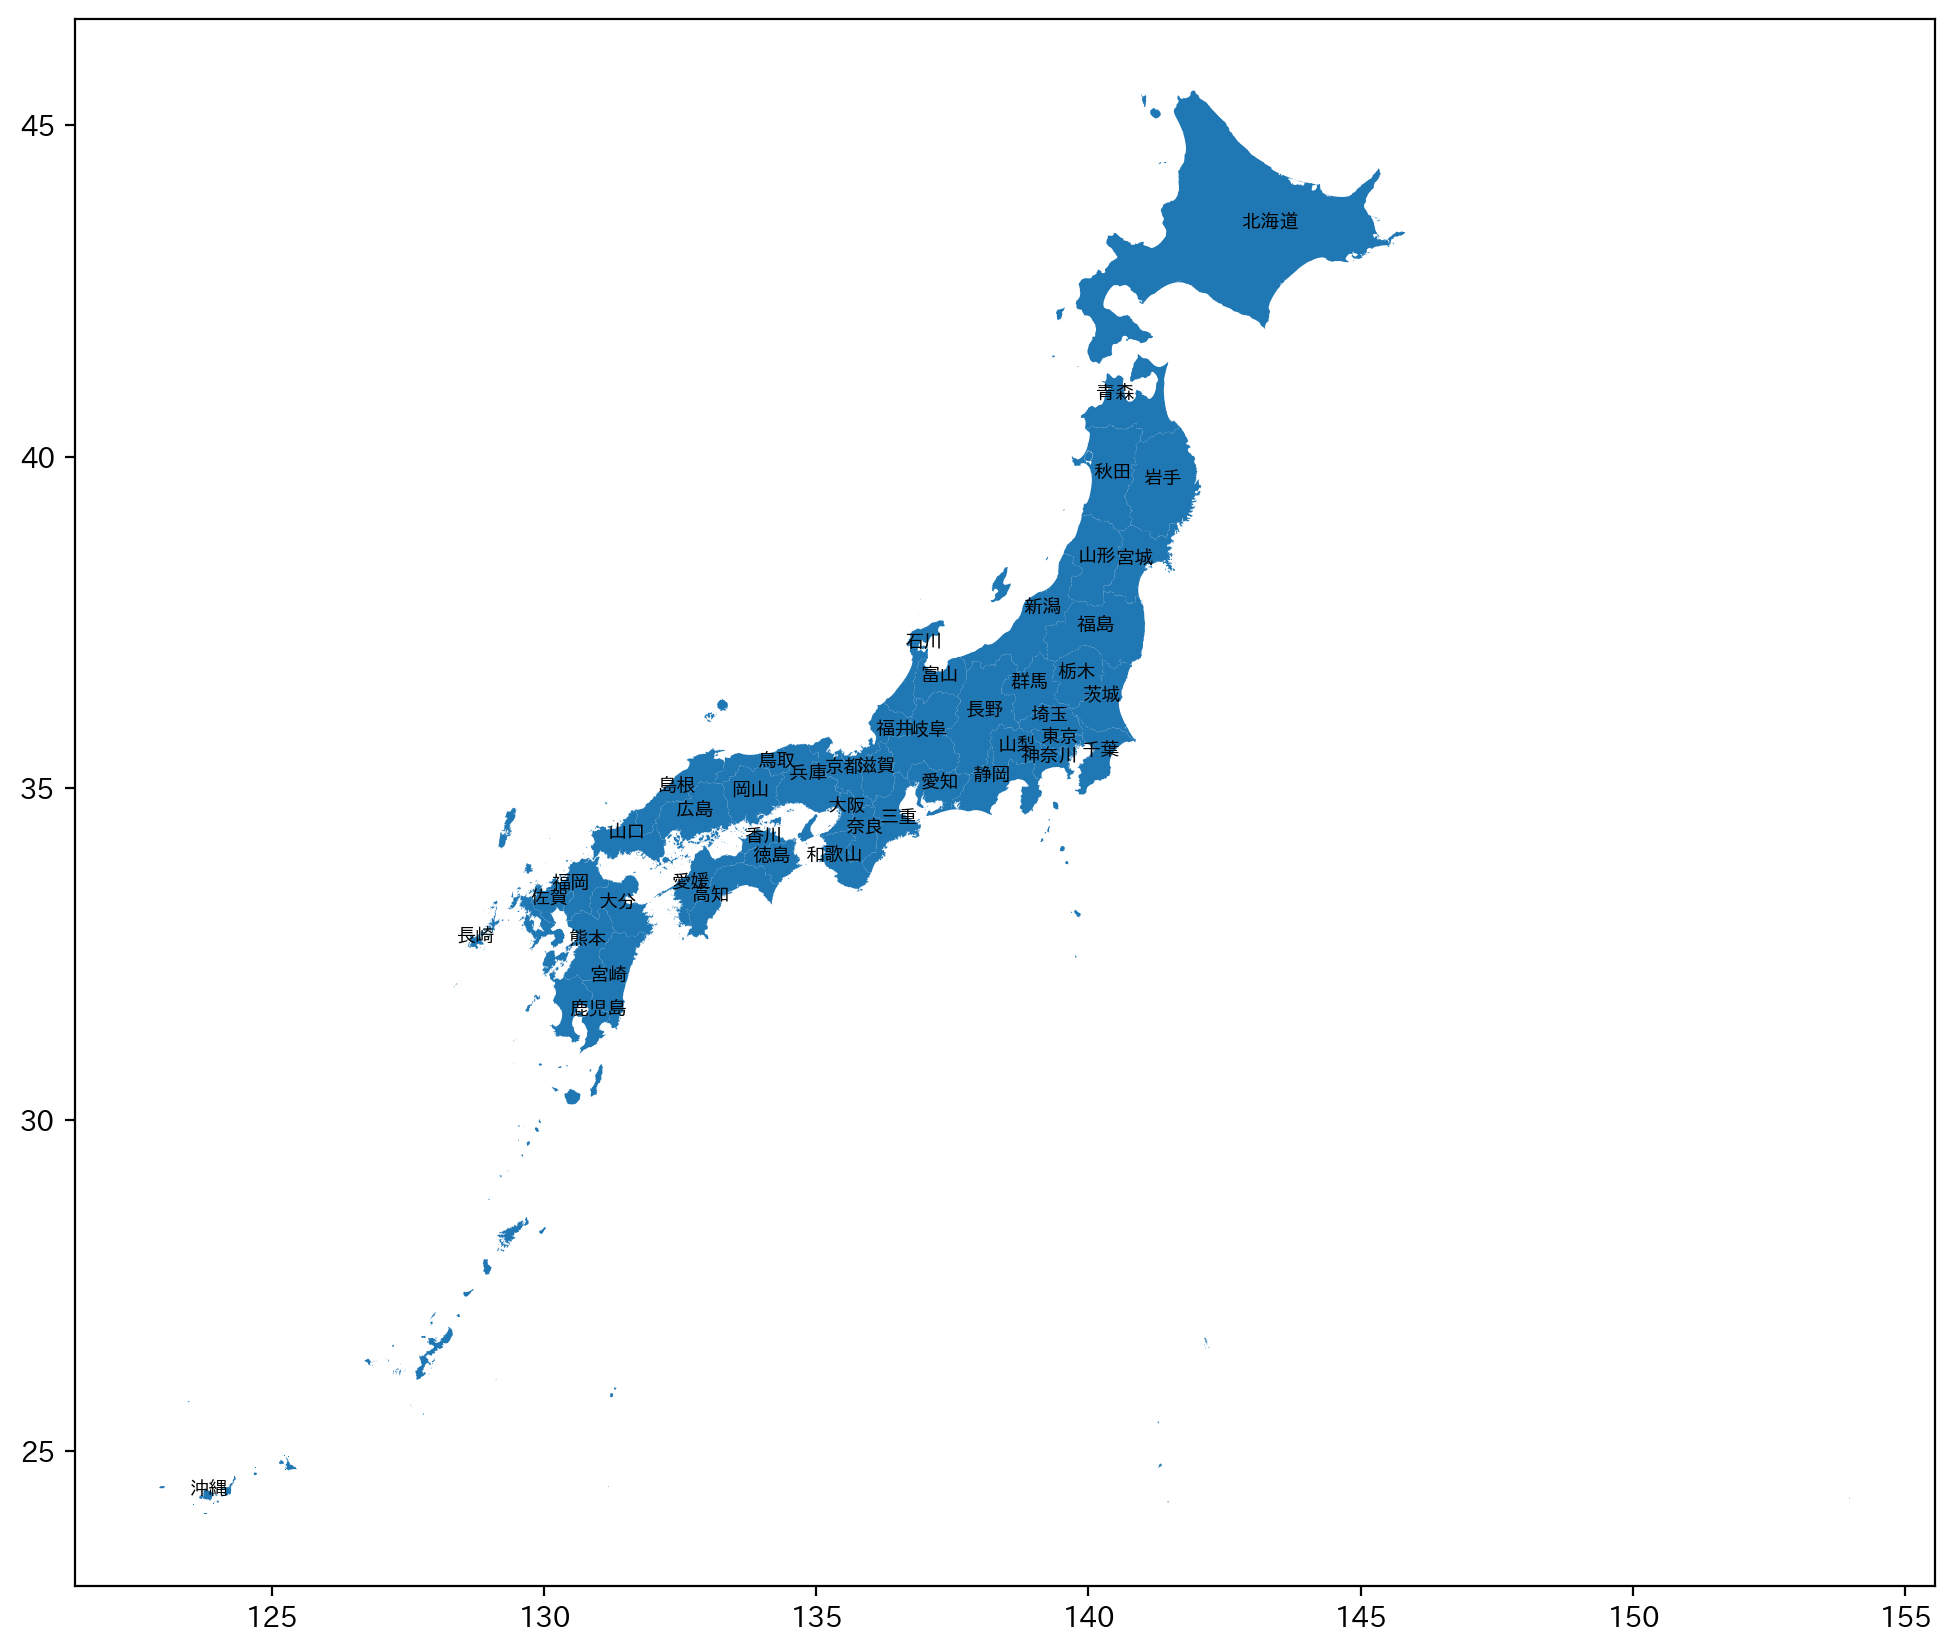

In [16]:
import re

ax = jpn_adm.plot(figsize=(12, 12))
# https://stackoverflow.com/questions/38899190/geopandas-label-polygons
for _idx, row in jpn_adm.iterrows():
  ax.annotate(re.sub(r'[都府県]$', '', row['prefecture']), xy=row['geometry'].representative_point().coords[0], ha='center', size='x-small')

`jpn_adm` と `marriage` をマージして、男女それぞれについて2019年の平均初婚年齢を地図上にプロットする。

In [17]:
marriage_with_adm = jpn_adm.merge(marriage, on='prefecture')

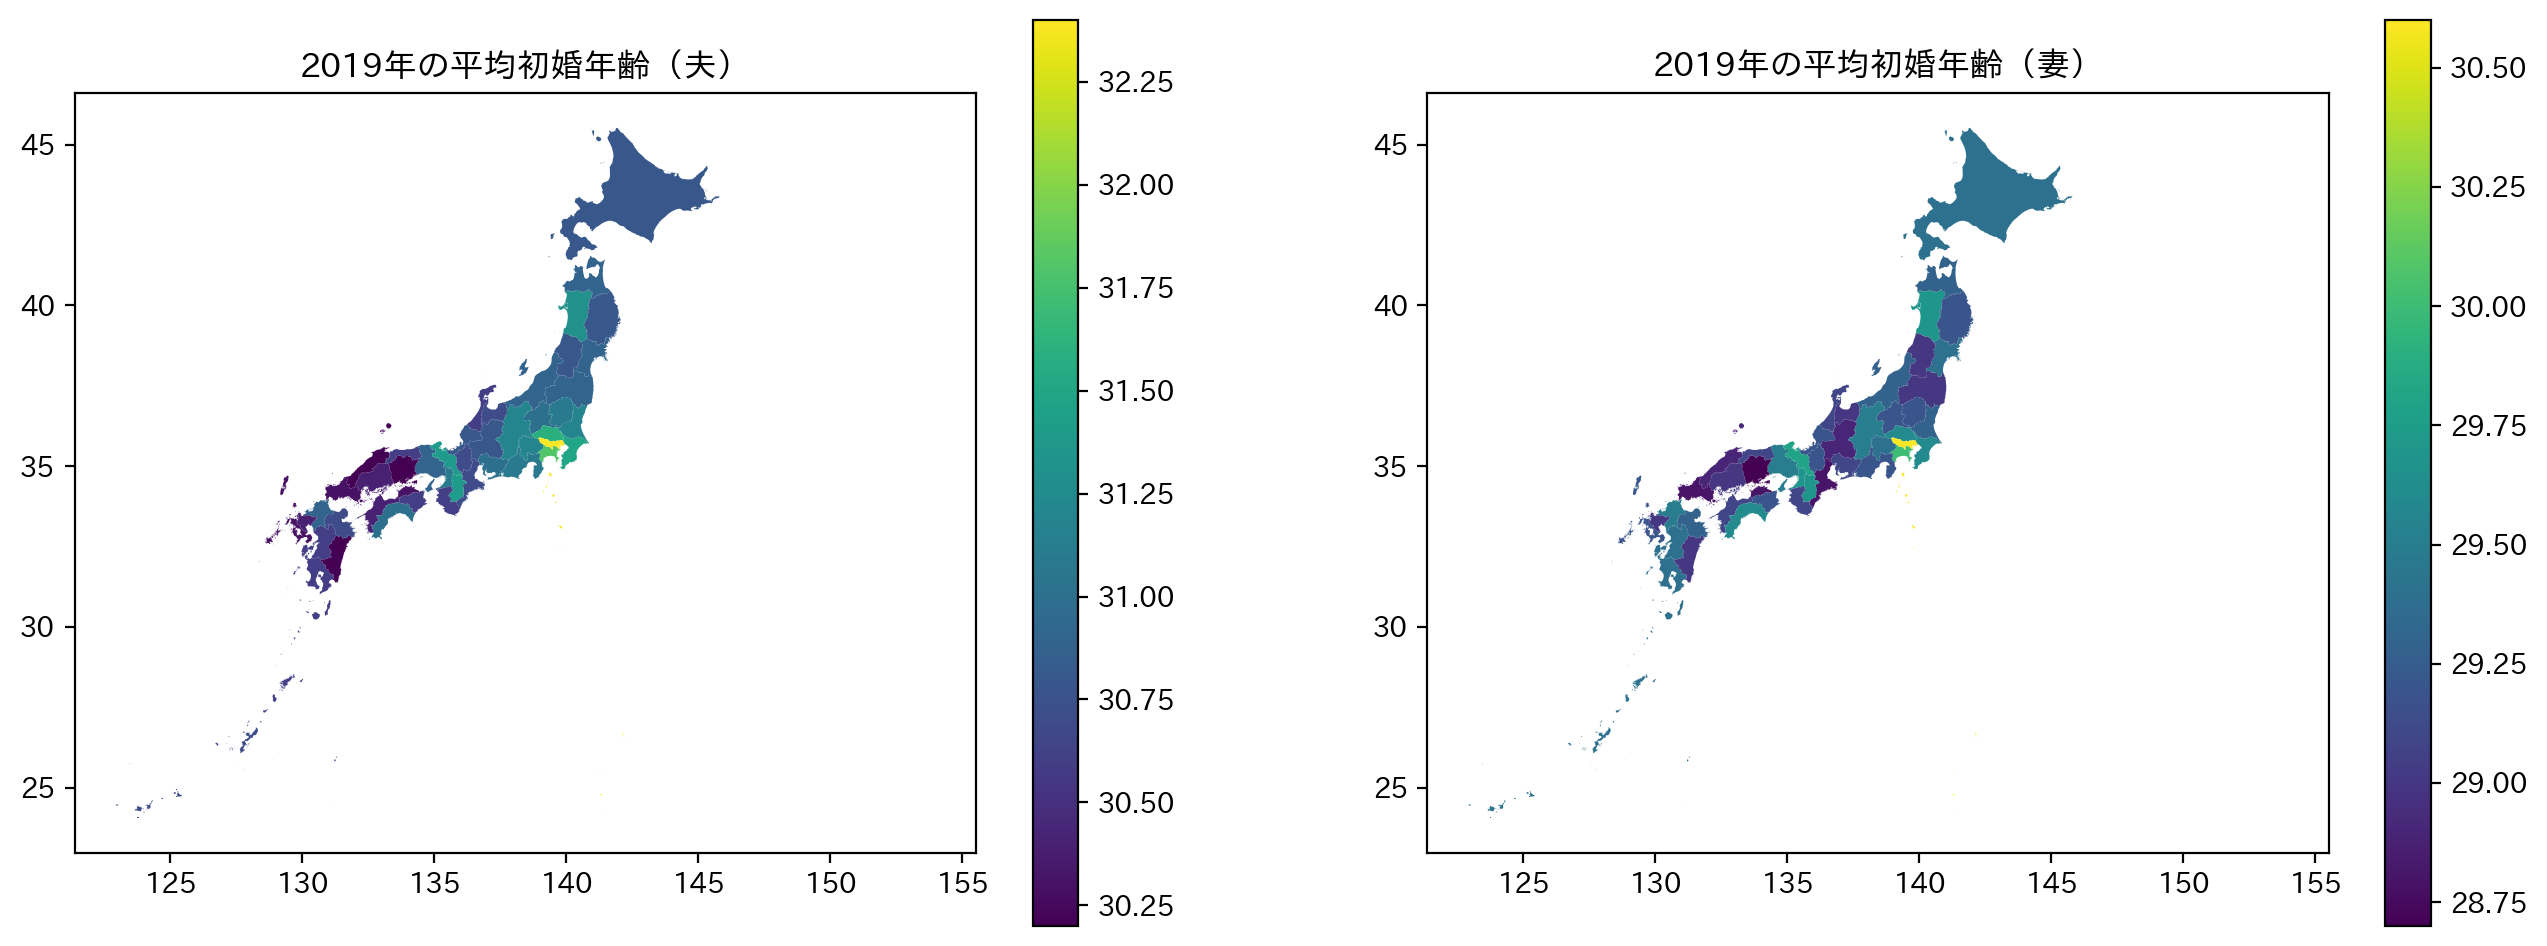

In [18]:
_fig, axs = plt.subplots(1, 2, figsize=(16, 6))

year = '2019年'
for ax, sex in zip(axs, ['夫', '妻']):
  ax.set_title(f'{year}の平均初婚年齢（{sex}）')
  marriage_with_adm[(marriage_with_adm['year'] == year) & (marriage_with_adm['sex'] == sex)].plot(column='ave_age', ax=ax, legend=True)

男女それぞれについて2015年と2019年の平均初婚年齢の差を地図上にプロットする。

In [19]:
marriage_by_year = marriage.pivot(index=['sex', 'prefecture'], columns='year', values='ave_age')
marriage_diff = (marriage_by_year['2015年'] - marriage_by_year['2019年']).reset_index(name='diff')
marriage_diff

,sex,prefecture,diff
0,夫,三重県,-0.1
1,夫,京都府,0.0
2,夫,佐賀県,-0.1
3,夫,兵庫県,0.0
4,夫,北海道,-0.1
...,...,...,...
89,妻,静岡県,0.0
90,妻,香川県,0.0
91,妻,高知県,0.0
92,妻,鳥取県,-0.2


In [20]:
diff_by_sex = marriage_diff.groupby('sex')['diff']
marriage_diff.loc[pd.concat([diff_by_sex.idxmin(), diff_by_sex.idxmax()])]

,sex,prefecture,diff
35,夫,福島県,-0.6
53,妻,和歌山県,-0.4
44,夫,高知県,0.3
60,妻,富山県,0.1


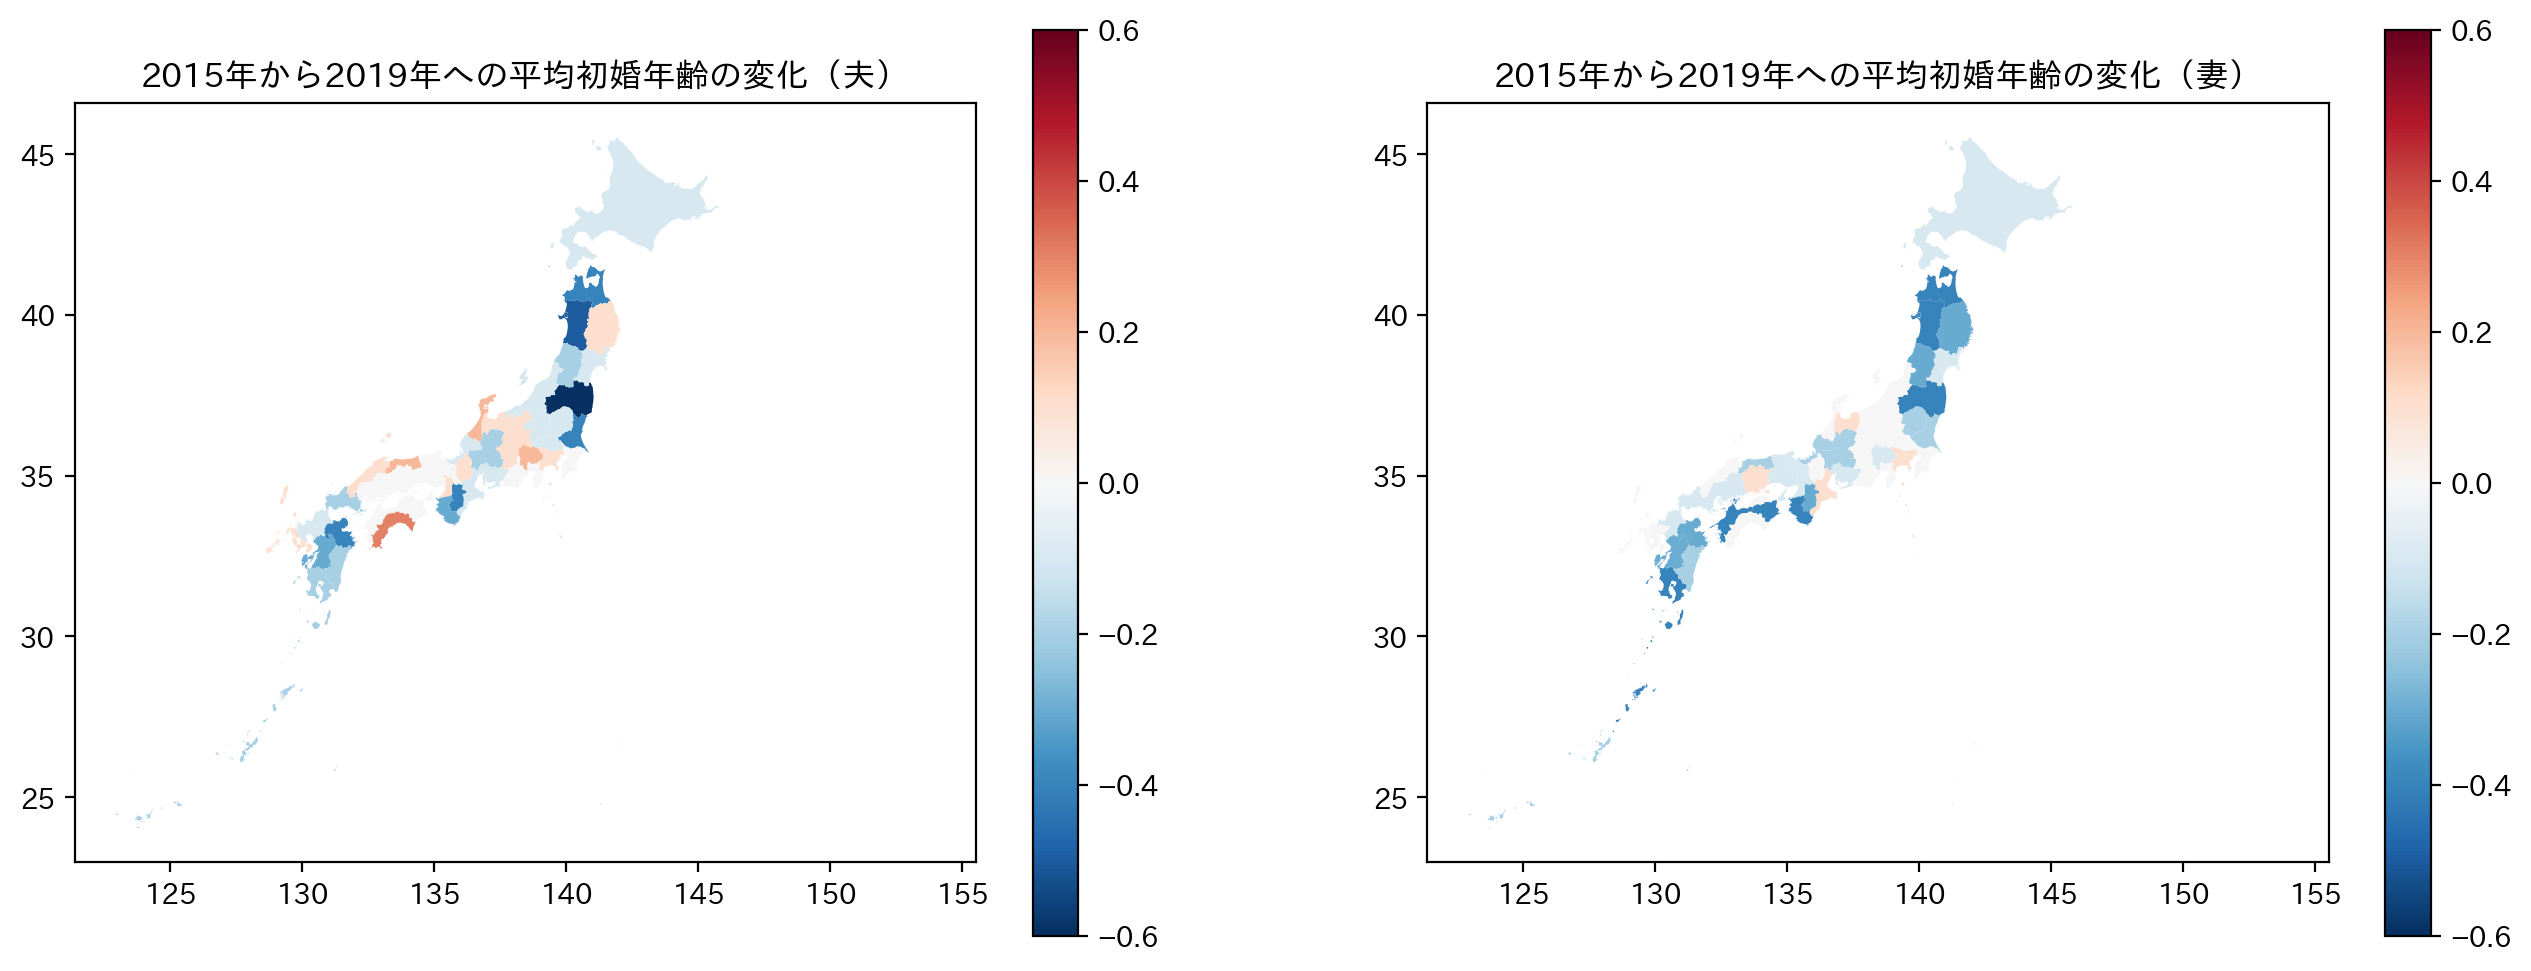

In [21]:
marriage_diff_with_adm = jpn_adm.merge(marriage_diff, on='prefecture')

_fig, axs = plt.subplots(1, 2, figsize=(16, 6))
for ax, sex in zip(axs, ['夫', '妻']):
  ax.set_title(f'2015年から2019年への平均初婚年齢の変化（{sex}）')
  marriage_diff_with_adm[marriage_diff_with_adm['sex'] == sex].plot(column='diff', ax=ax, cmap='RdBu_r', vmin=-0.6, vmax=0.6, legend=True)

## 座標系

`jpn_adm` の座標参照系（CRS: Coordinate Reference System）を表示する。

In [22]:
jpn_adm.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

4種類の座標系で日本を表示する。

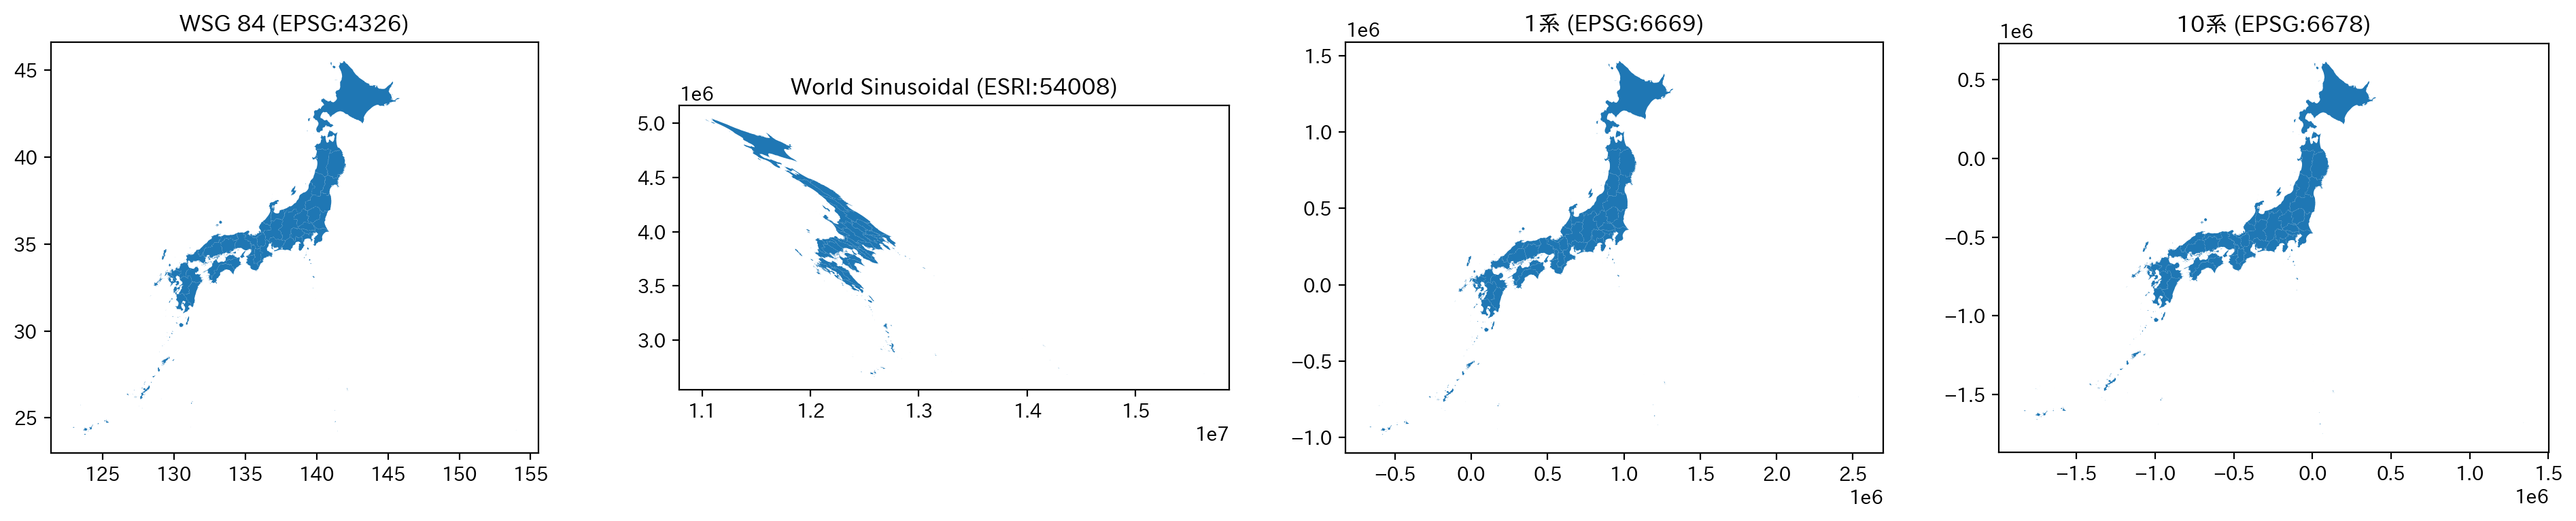

In [23]:
_fig, axs = plt.subplots(1, 4, figsize=(24, 4))

crs_and_title_list = [
    ('EPSG:4326', 'WSG 84'),
    ('ESRI:54008', 'World Sinusoidal'),
    ('EPSG:6669', '1系'),
    ('EPSG:6678', '10系')
]

for ax, (crs, title) in zip(axs, crs_and_title_list):
  ax.set_title(f'{title} ({crs})')
  jpn_adm.to_crs(crs).plot(ax=ax)